In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load Vanilla Ice Dataset

This time series is a TS extracted from the pop song Ice Ice Baby by Vanilla Ice using the 2nd MFCC channel sampled at 100Hz [1]. This TS is particularly famous pop song, as it is alleged to have copied its riff from "Under Pressure" by Queen and David Bowie. It contains 20 repeats of the riff in 5 blocks with each riff being 3.6−4s long.

### References
[1] Chin-Chia Michael Yeh,Yan Zhu, Liudmila Ulanova, Nurjahan Begum, Yifei Ding, Hoang Anh Dau, Diego Furtado Silva, Abdullah Mueen, and Eamonn Keogh. 2016. Matrix profile I: all pairs similarity joins for time series: a unifying view that includes motifs, discords and shapelets. In 2016 IEEE 16th international conference on data mining (ICDM). Ieee, 1317–1322.

Dataset Original Length n:  23095
Dataset Sampled Length n:  11548
../datasets/ground_truth/vanilla_ice_gt.csv


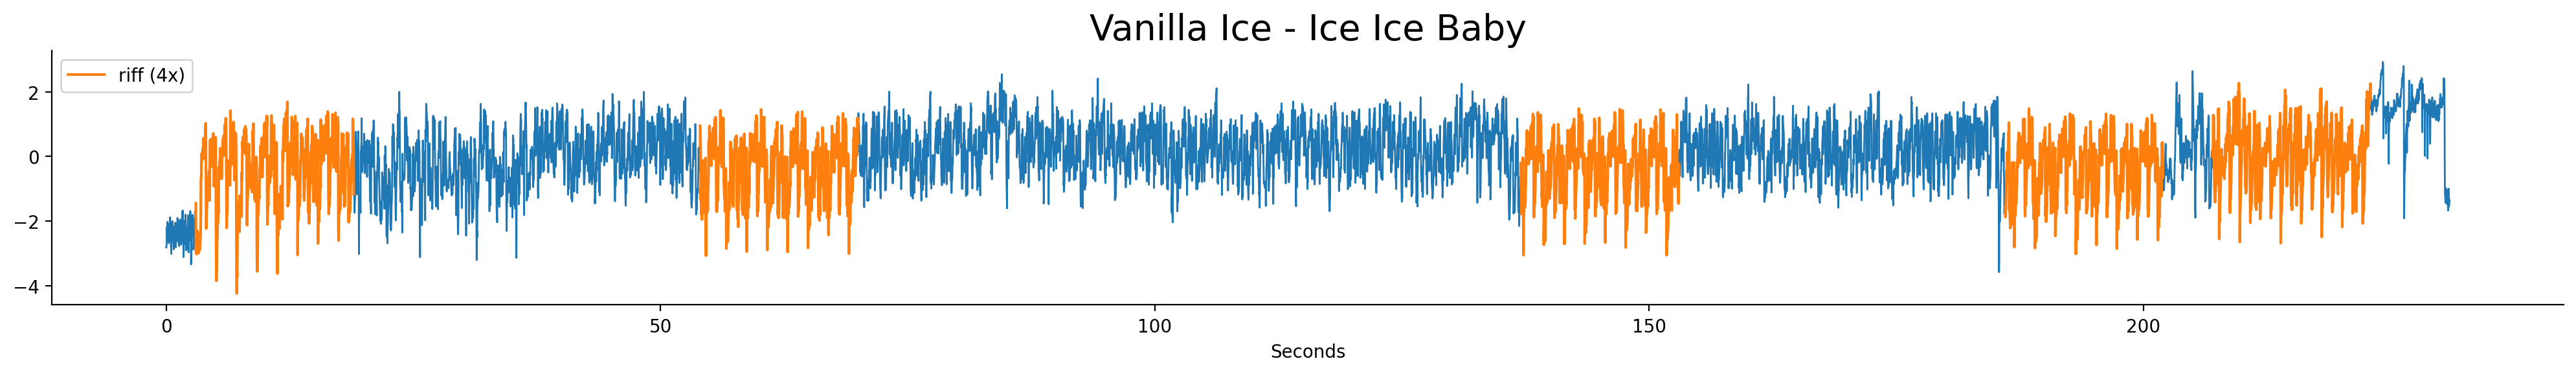

(<Figure size 2000x300 with 1 Axes>,
 [<Axes: title={'center': 'Vanilla Ice - Ice Ice Baby'}, xlabel='Seconds'>])

In [2]:
ds_name = "Vanilla Ice - Ice Ice Baby"
file = 'vanilla_ice.csv'

series, df_gt = ml.read_dataset_with_index(file) # , sampling_factor=np.inf
plot_dataset(ds_name, series, ground_truth=df_gt)

# Known Motifs

There is one motif: the famous riff. Listening to these songs it is easy to obtain an initial guess of the number of repetitions (parameter 𝑘) of the problematic sections. On the other hand, it is impossible for humans to guess a good value for the numerical, real-valued distance between the different repetitions (parameter r).

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1 motifs
rerun_all_jars = False
ks=22
motif_length = 180
slack=0.6
dataset = os.getcwd() + '/../datasets/' + file

# k-Motiflets

## Next, we learn the size k of the motif set

We plot the similarity of the motifs as a function of the cardinality of $k$-Motiflets to their extent. Elbow points represent large changes in similarity of the found motif set, indicative of a concept change.

In the following plots, we one characteristic motif: the riff.

Data 11548


Compute ks (22):   0%|          | 0/20 [00:00<?, ?it/s]

Chosen window-size: 180 in 1.1 s
Elbow Points [20]


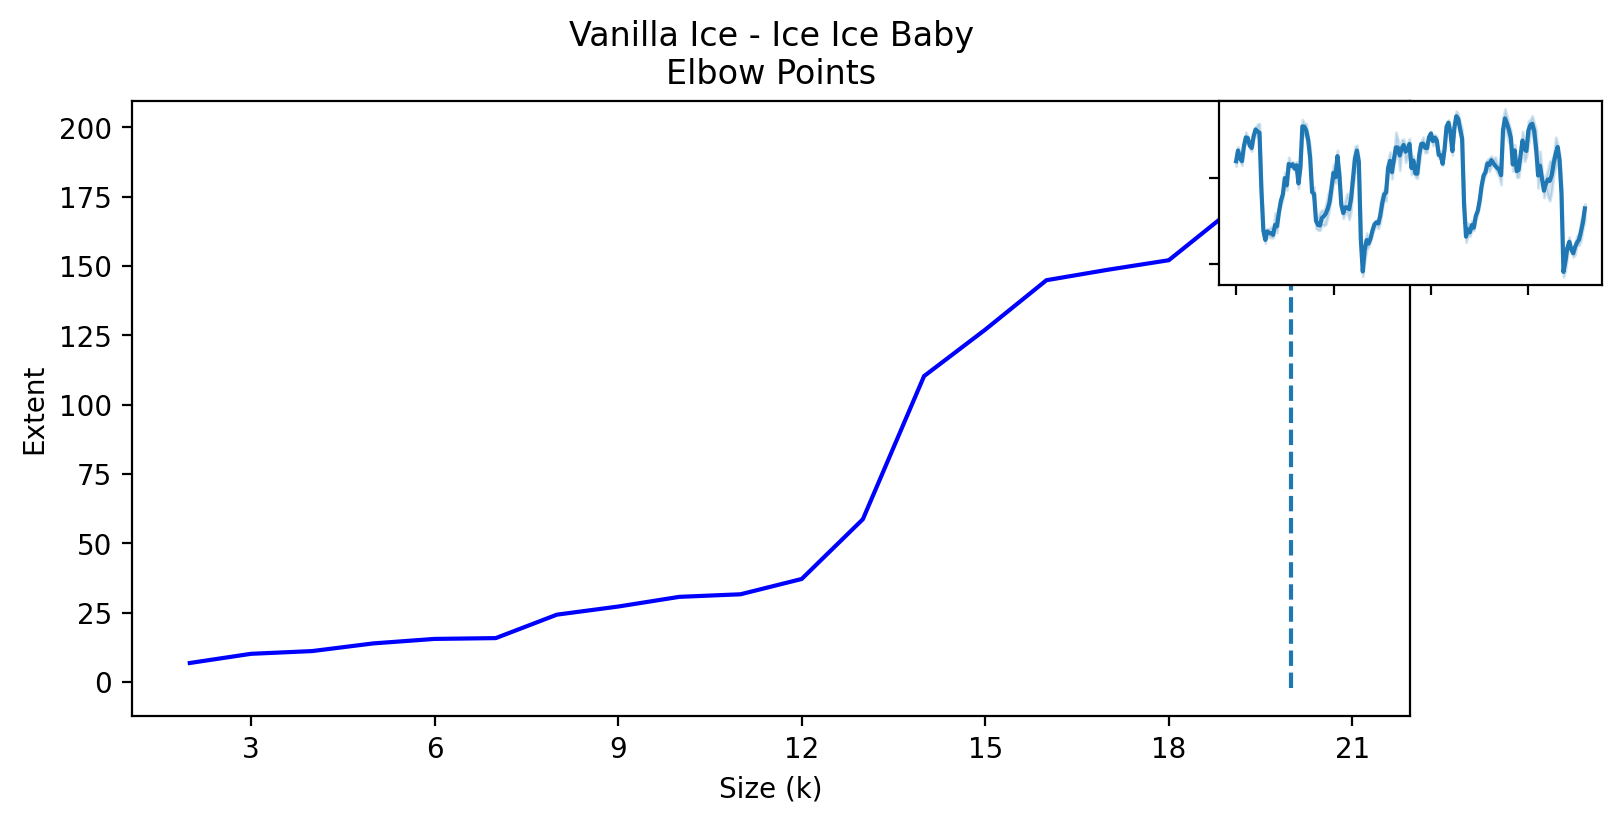

Data 11548


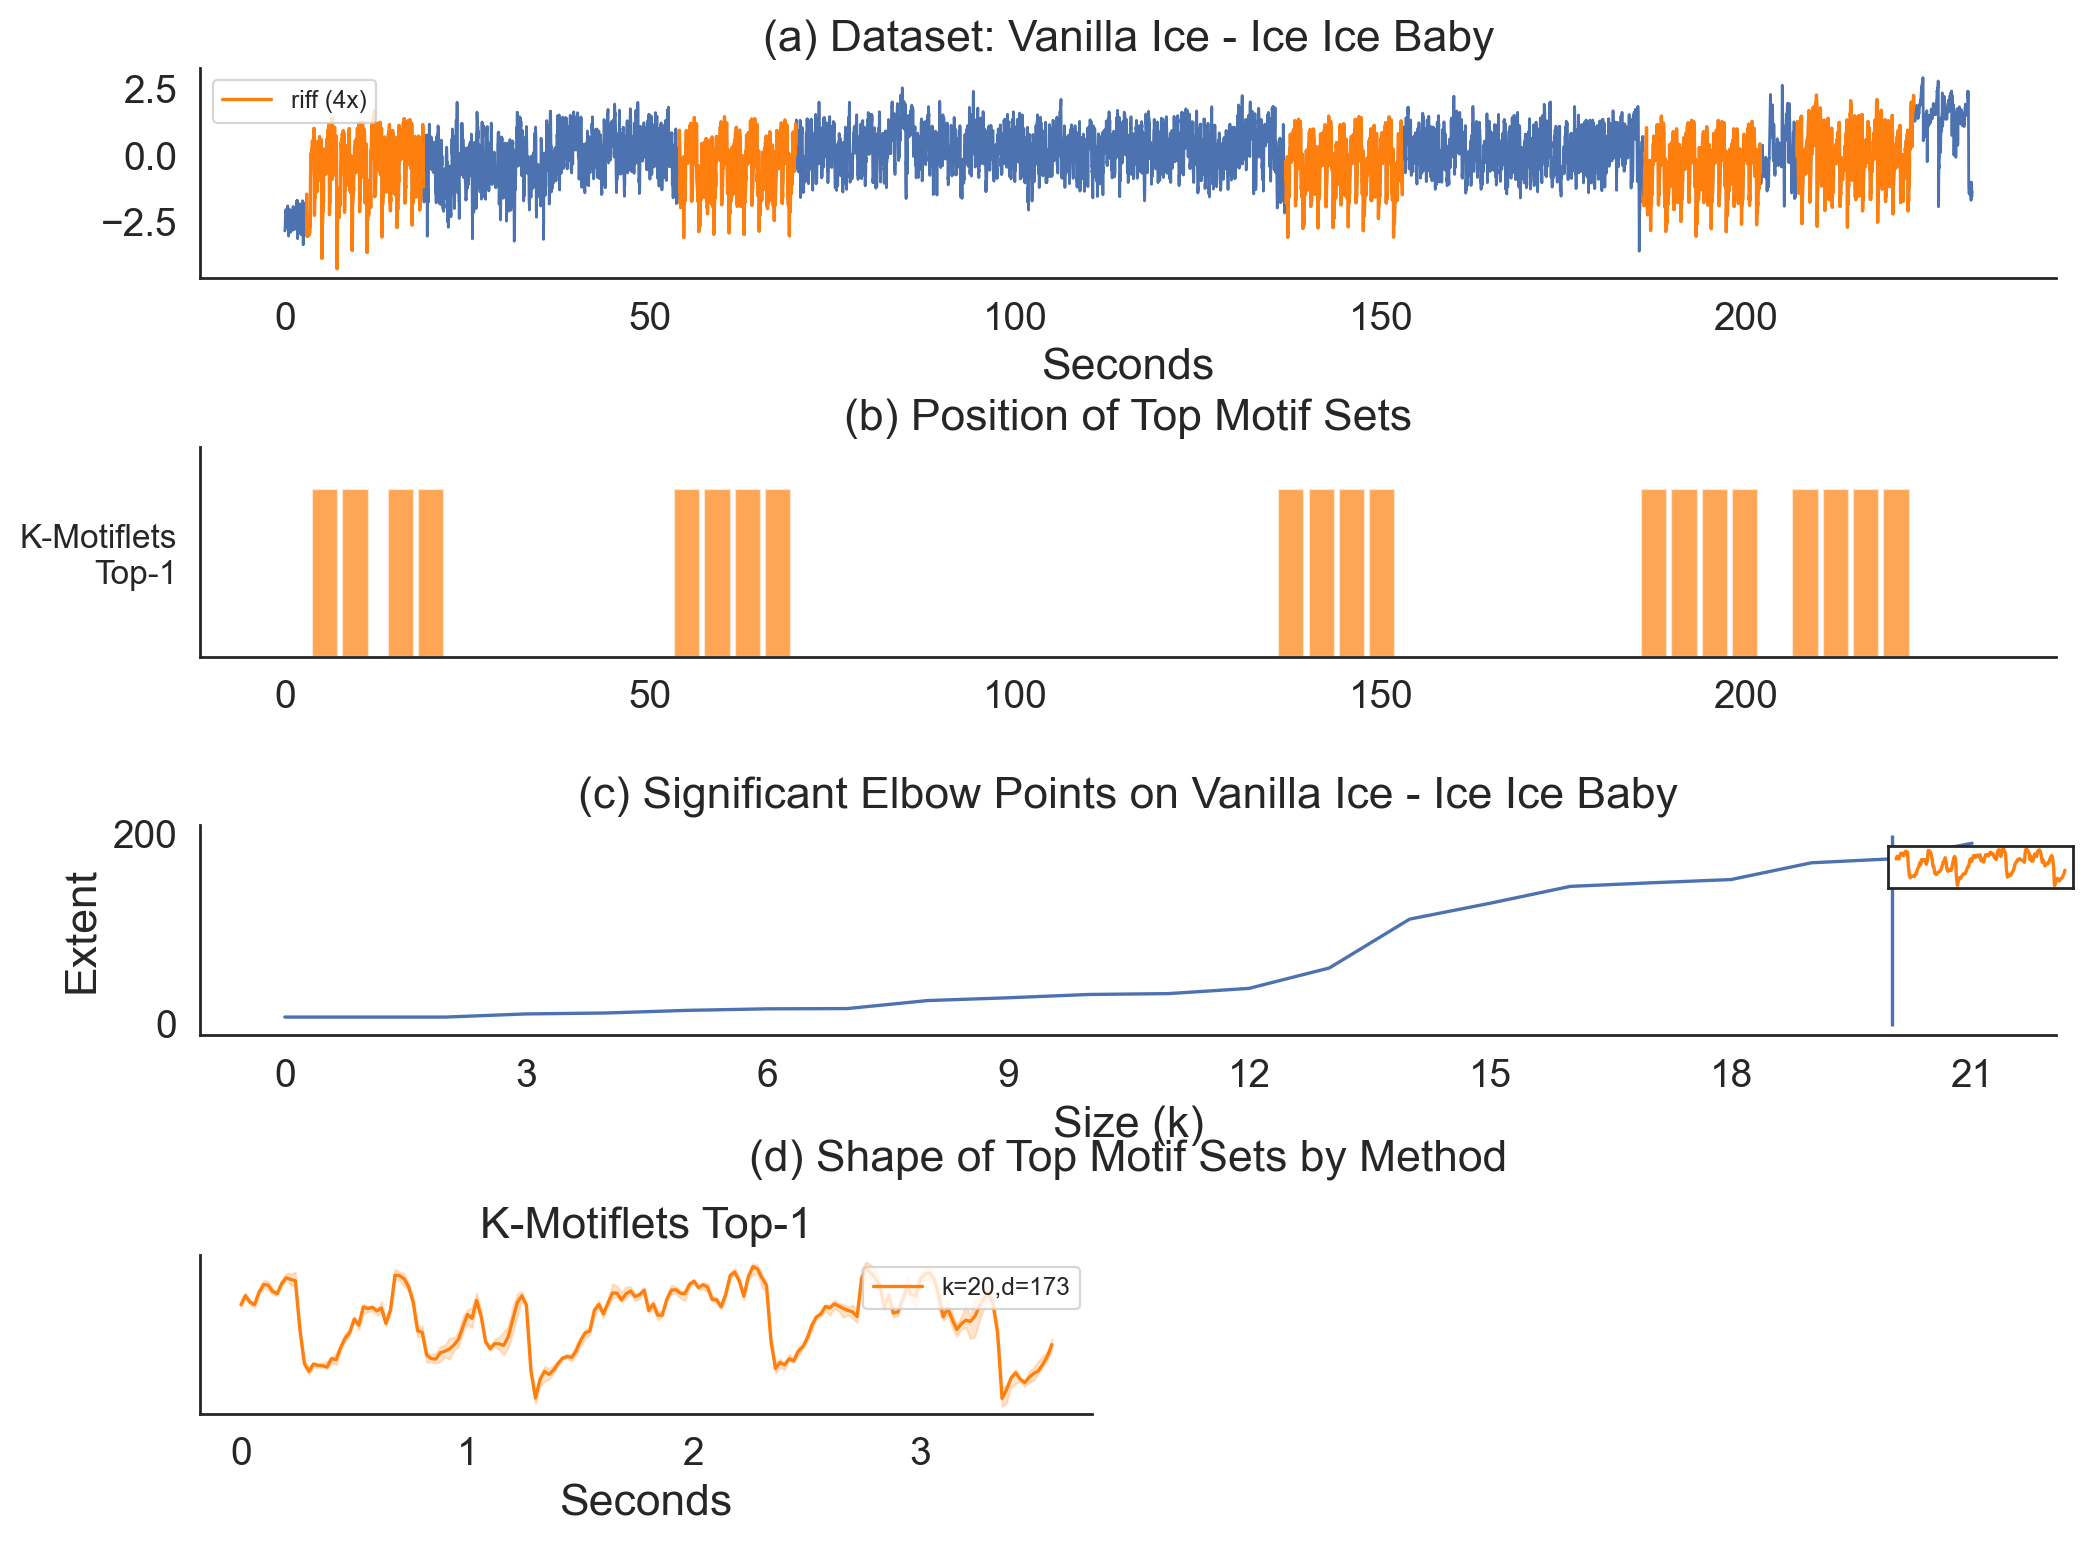

In [4]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="K-Motiflets", 
    ground_truth=df_gt, slack=slack)

# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error. 

We use the results of $k$-Motiflets as silver standard and compare the ability of the other methods to recover the respective motifs. To enable such a comparison, we provided the competitors with proper values of $r$ and $l$, derived from the silver standard, but also with an added noise of $-10\%$ and $+10\%$ to reflect trial-and-error tuning.

In [5]:
data = series.values
D_full = ml.compute_distances_full(data, motif_length)
df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]

r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])

print("Radius r of TOP-1 Motifs", r_top1)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

radii = np.array([r_top1])
print("Radii r", radii)
print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

# Human error due to trial-and-error
errors = [0, -0.10, 0.10]

Radius r of TOP-1 Motifs 128.54295349121094
Extent d of TOP-1 Motif 173.97723388671875
Radii r [128.54295349]
Best Radii	 [128.54295349]
Best Lengths	 180


# Competitors

We compare our $k$-Motiflets to the state-of-the-art motif set discovery methods. These are based on different definitions as follow:

<img src="images/motif_definitions.png"/>

# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [6]:
rs = np.array([r_top1*0.82])   # r_top1: 104.35116964
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/set_finder.jar',
           dataset,
           'SetFinder',
           str(list(rs)),
           str(mls)])

Now, we show the found motifs

,offsets
SF Top-1,"[186, 391, 494, 701, 805, 2870, 3076, 3283, 67..."
SF Top-1 -10%,"[7265, 446, 755, 2716, 2922, 3129, 3336, 6850,..."
SF Top-1 +10%,"[176, 381, 484, 588, 692, 795, 2963, 3066, 316..."


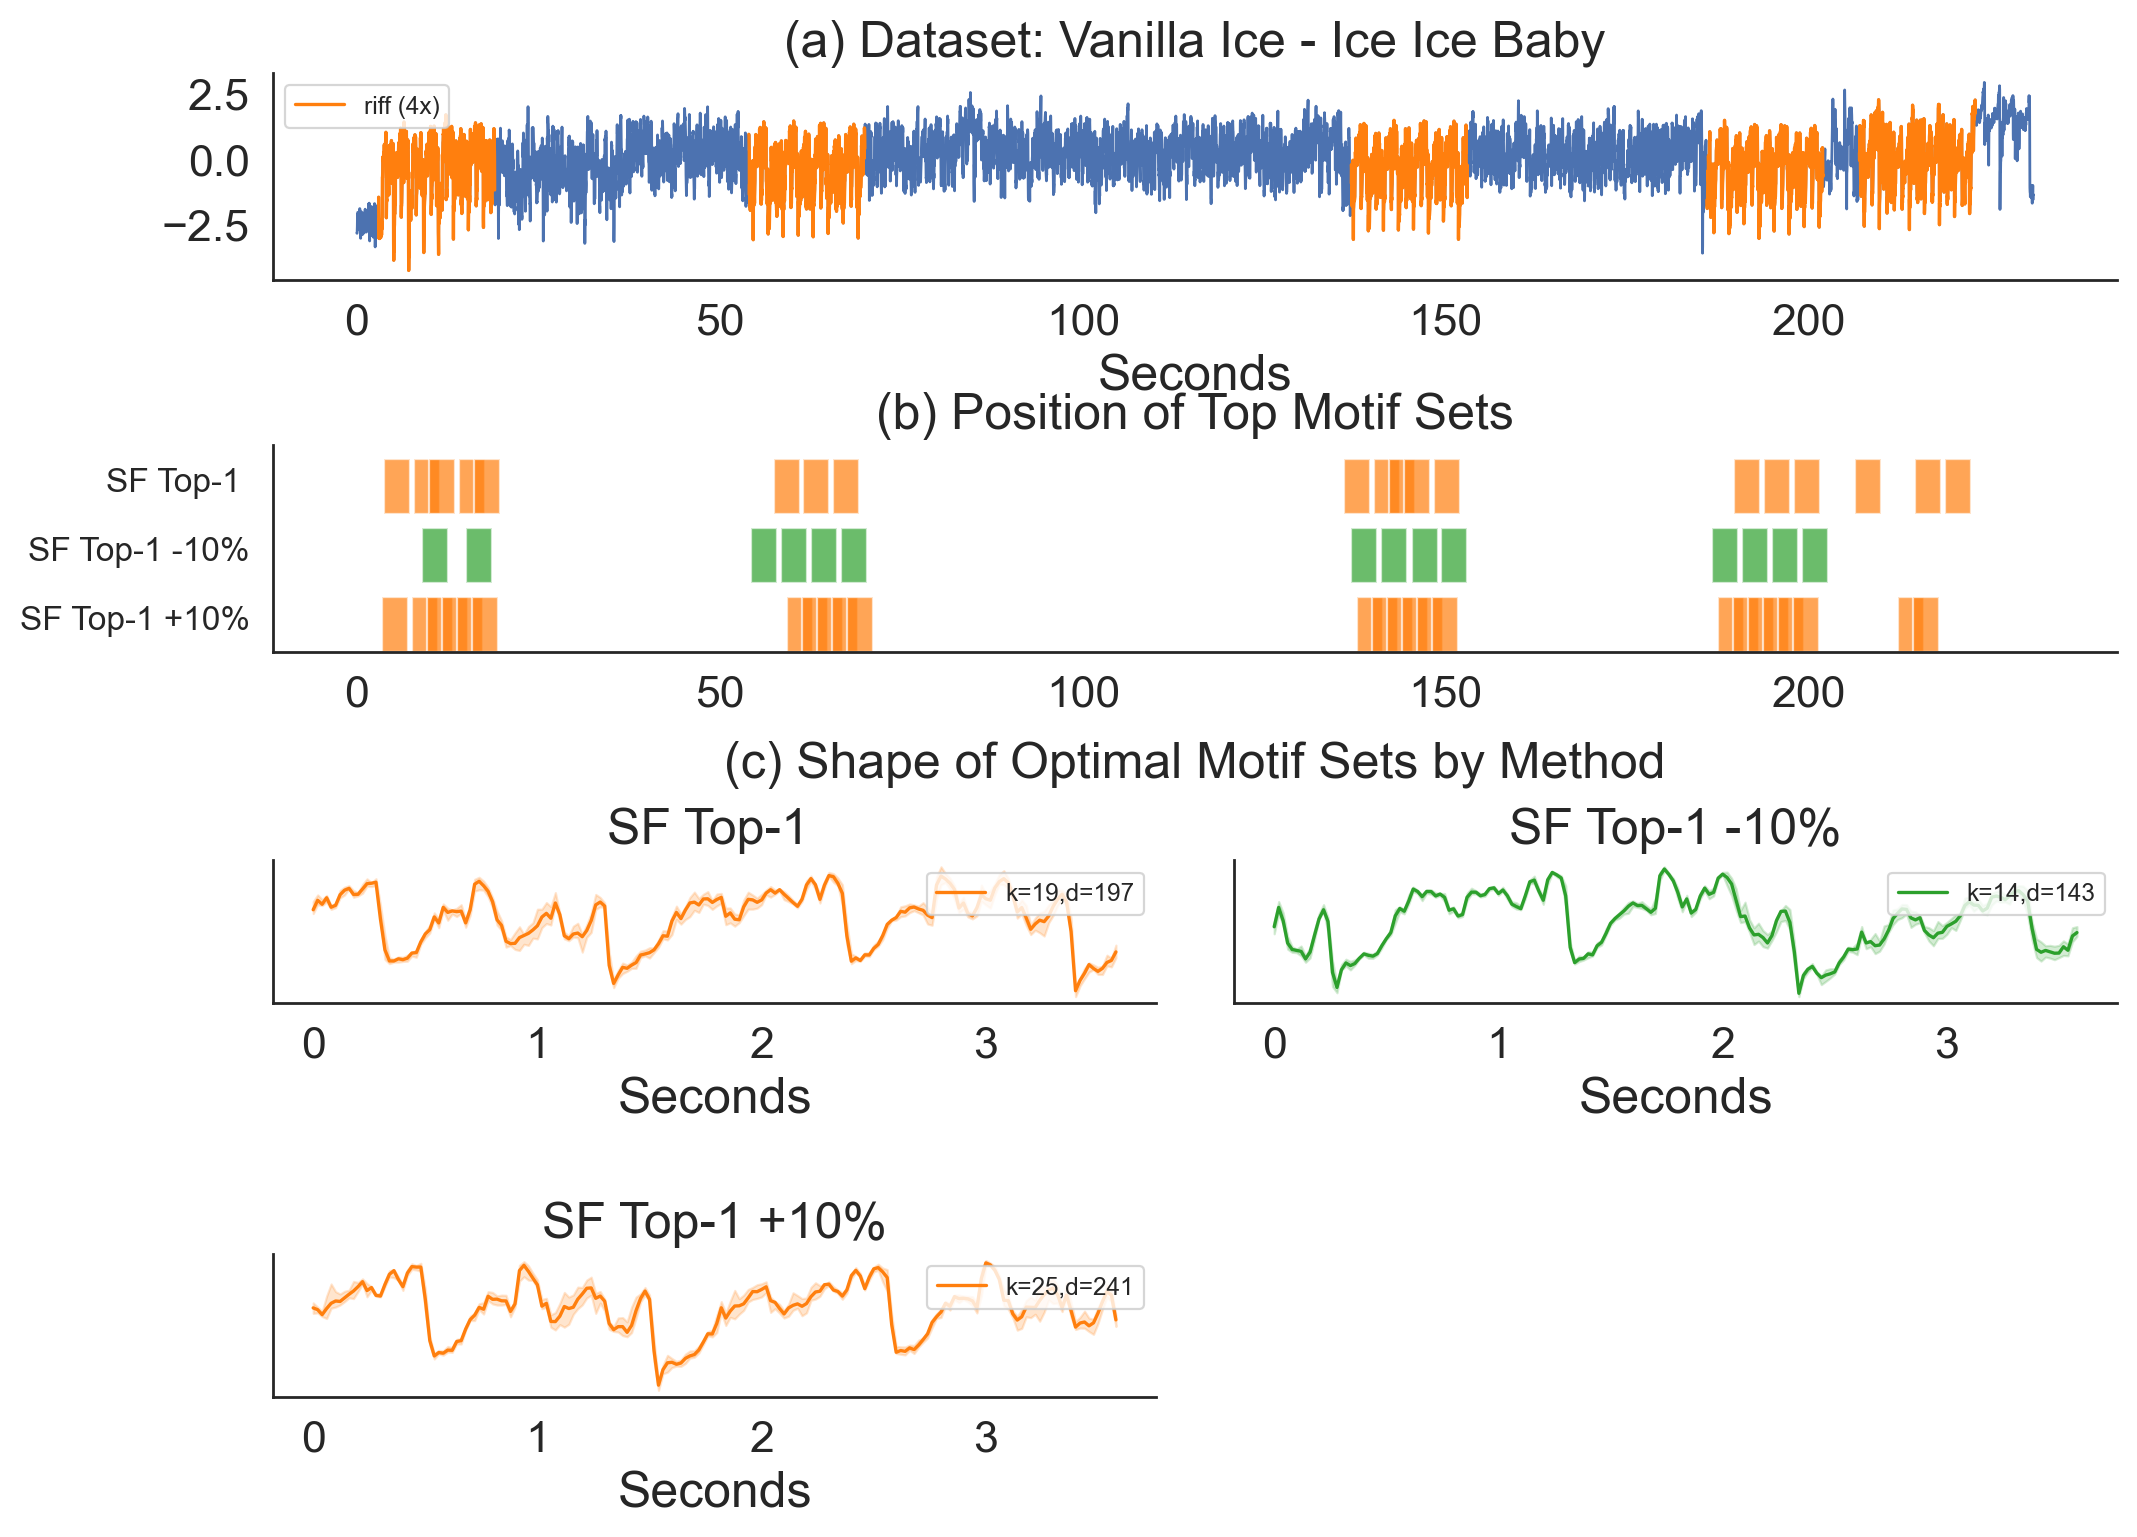

In [7]:
# run jave code first       
ms_all = {
    "" : [
	[186, 391, 494, 701, 805, 2870, 3076, 3283, 6797, 7004, 7108, 7211, 7418, 9488, 9695, 9902, 10317, 10731, 10938],
    ],
    "-10%" : [
	[7265, 446, 755, 2716, 2922, 3129, 3336, 6850, 7057, 7471, 9334, 9541, 9748, 9956],
    ],
    "+10%" : [
	[176, 381, 484, 588, 692, 795, 2963, 3066, 3169, 3273, 3376, 6891, 6994, 7097, 7201, 7304, 7408, 9374, 9478, 9581, 9685, 9788, 9892, 10617, 10721],
    ]
}

motifsets = to_df(ms_all, "SF", df)
display(motifsets)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)


Set Finder (SF) found at most 19 repeats, and with slightly different parameterization the results get much worse.

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [8]:
rs = np.array([r_top1*0.925])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/emma.jar',
           dataset,
           str(list(rs)),
           str(mls)])

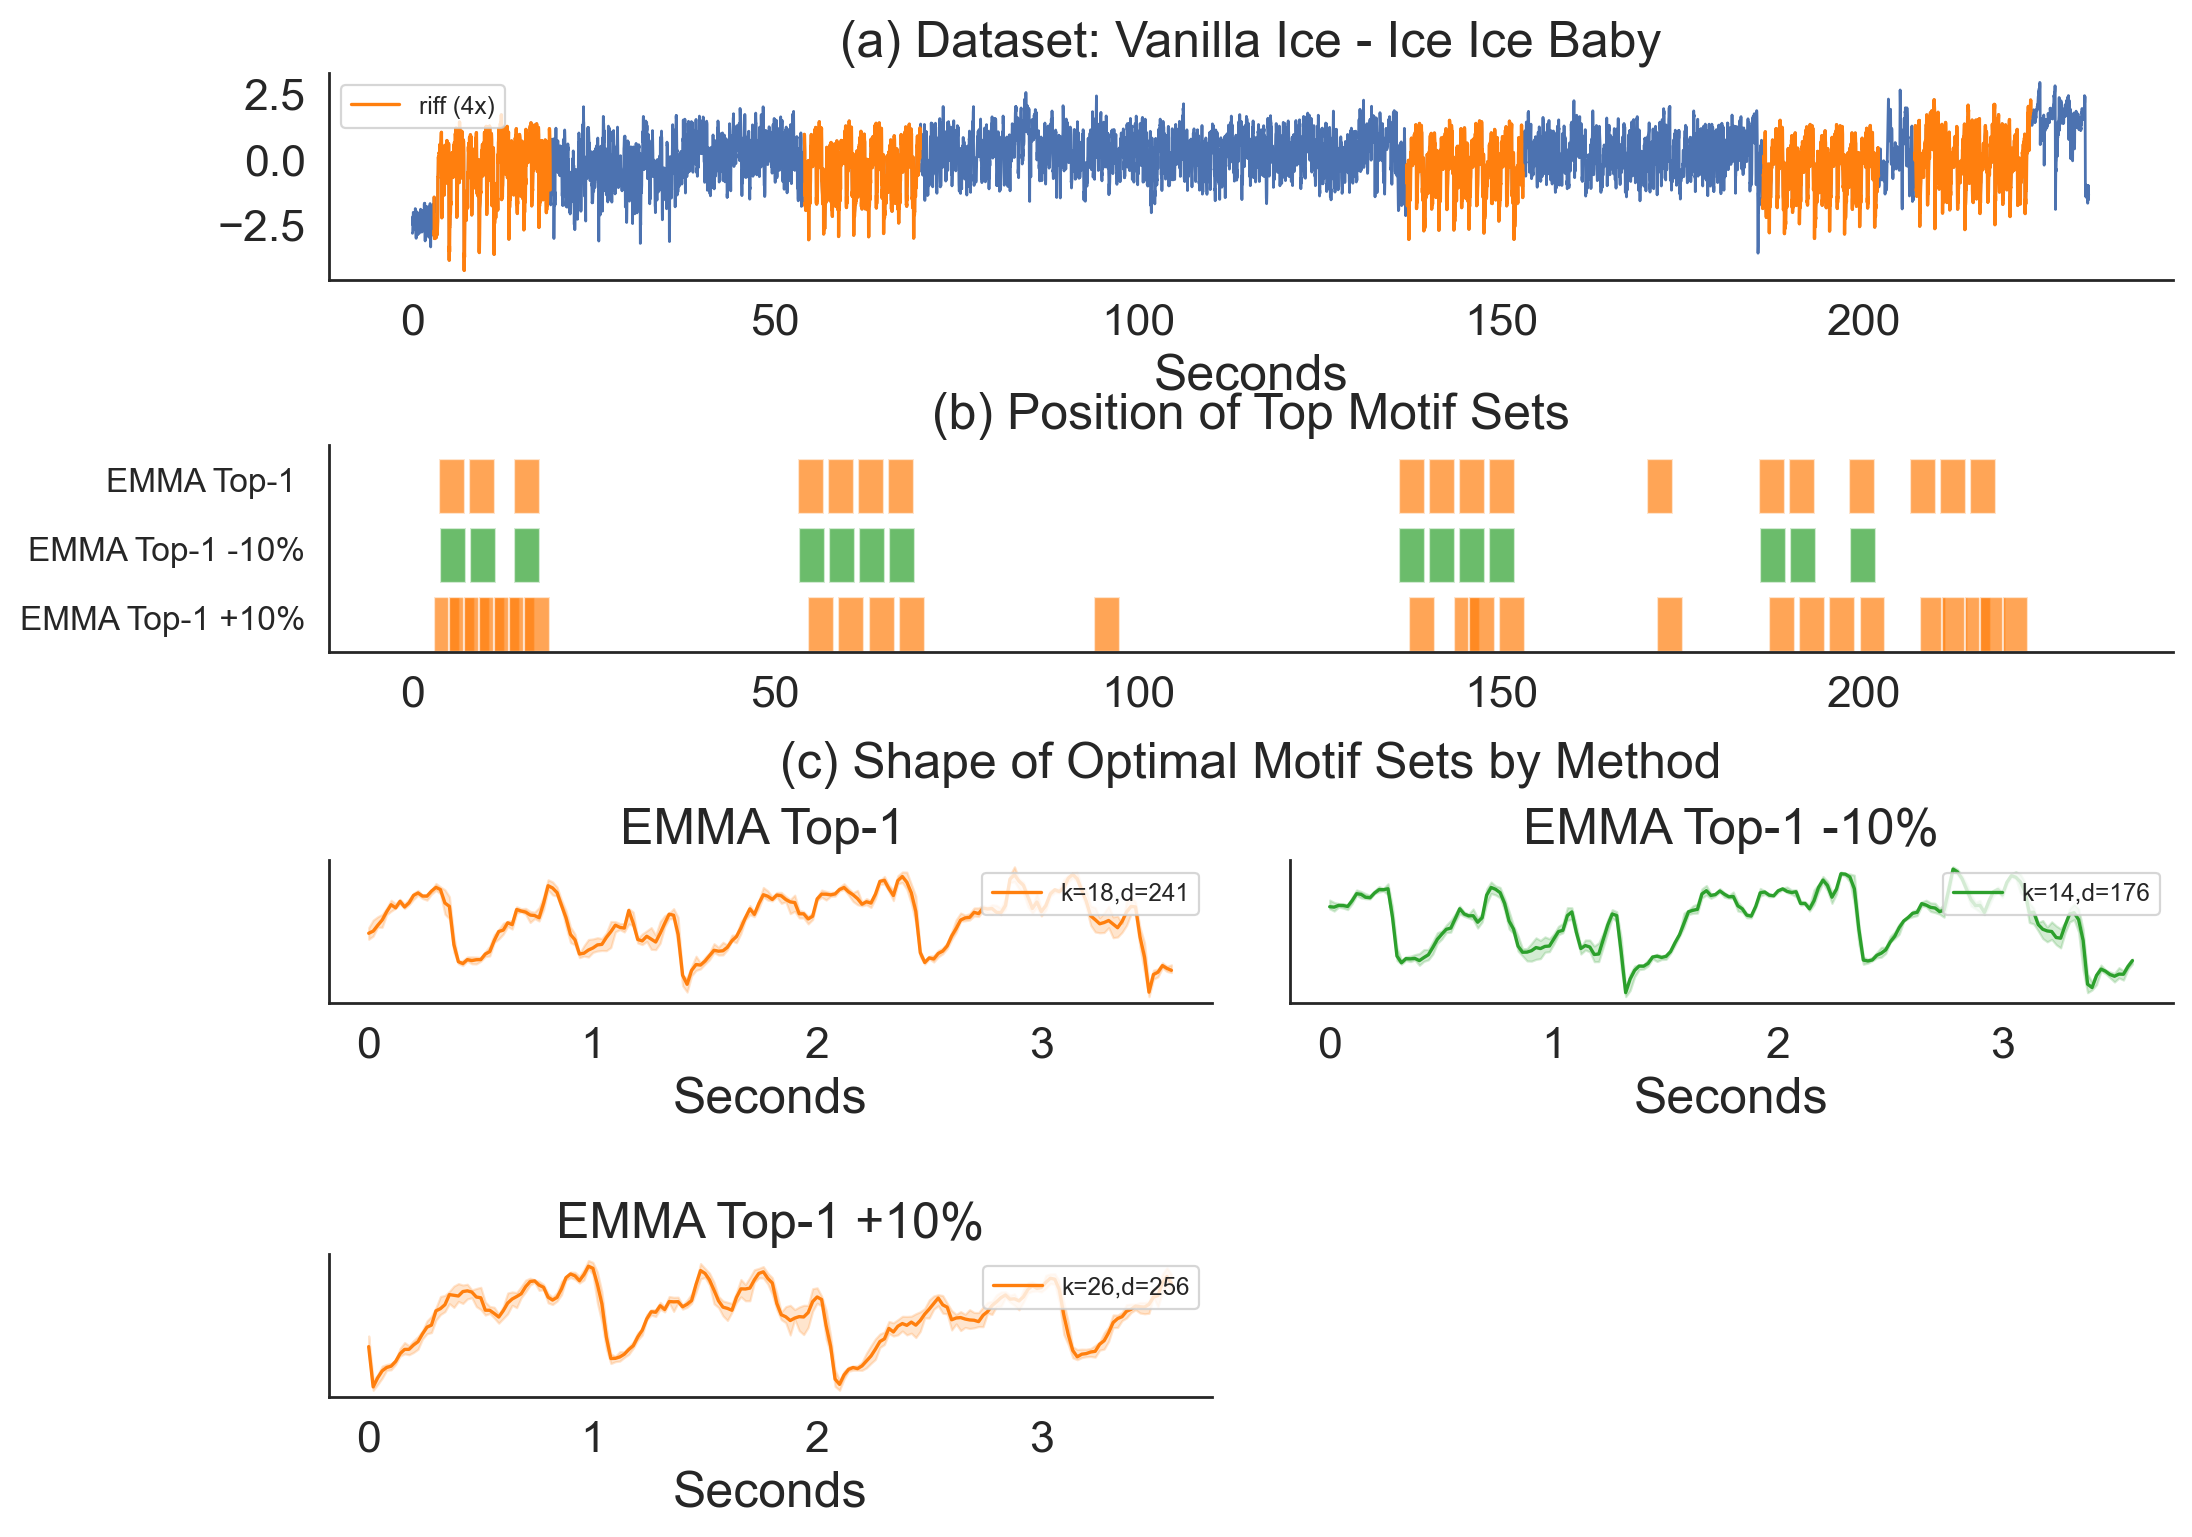

In [9]:
# run jave code first       
ms_all = {
    "" : [
	[183, 389, 699, 2659, 2866, 3072, 3279, 6793, 7000, 7207, 7414, 8504, 9277, 9484, 9898, 10314, 10521, 10729],
    ], 
    "-10%" :[
	[188, 394, 703, 2663, 2870, 3077, 3283, 6798, 7005, 7212, 7418, 9281, 9489, 9903],
    ],
    "+10%" :[
	[150, 252, 356, 458, 562, 666, 767, 2728, 2935, 3142, 3349, 4694, 6863, 7175, 7277, 7484, 8572, 9346, 9553, 9760, 9968, 10383, 10539, 10695, 10799, 10953],
    ]
}


motifsets = to_df(ms_all, "EMMA", df)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)



EMMA's found at most 18 repeats with optimal parameters and results get worse when changing input parameter slightly.

# Valmod Motif Sets
based on own (fixed-length) implementation

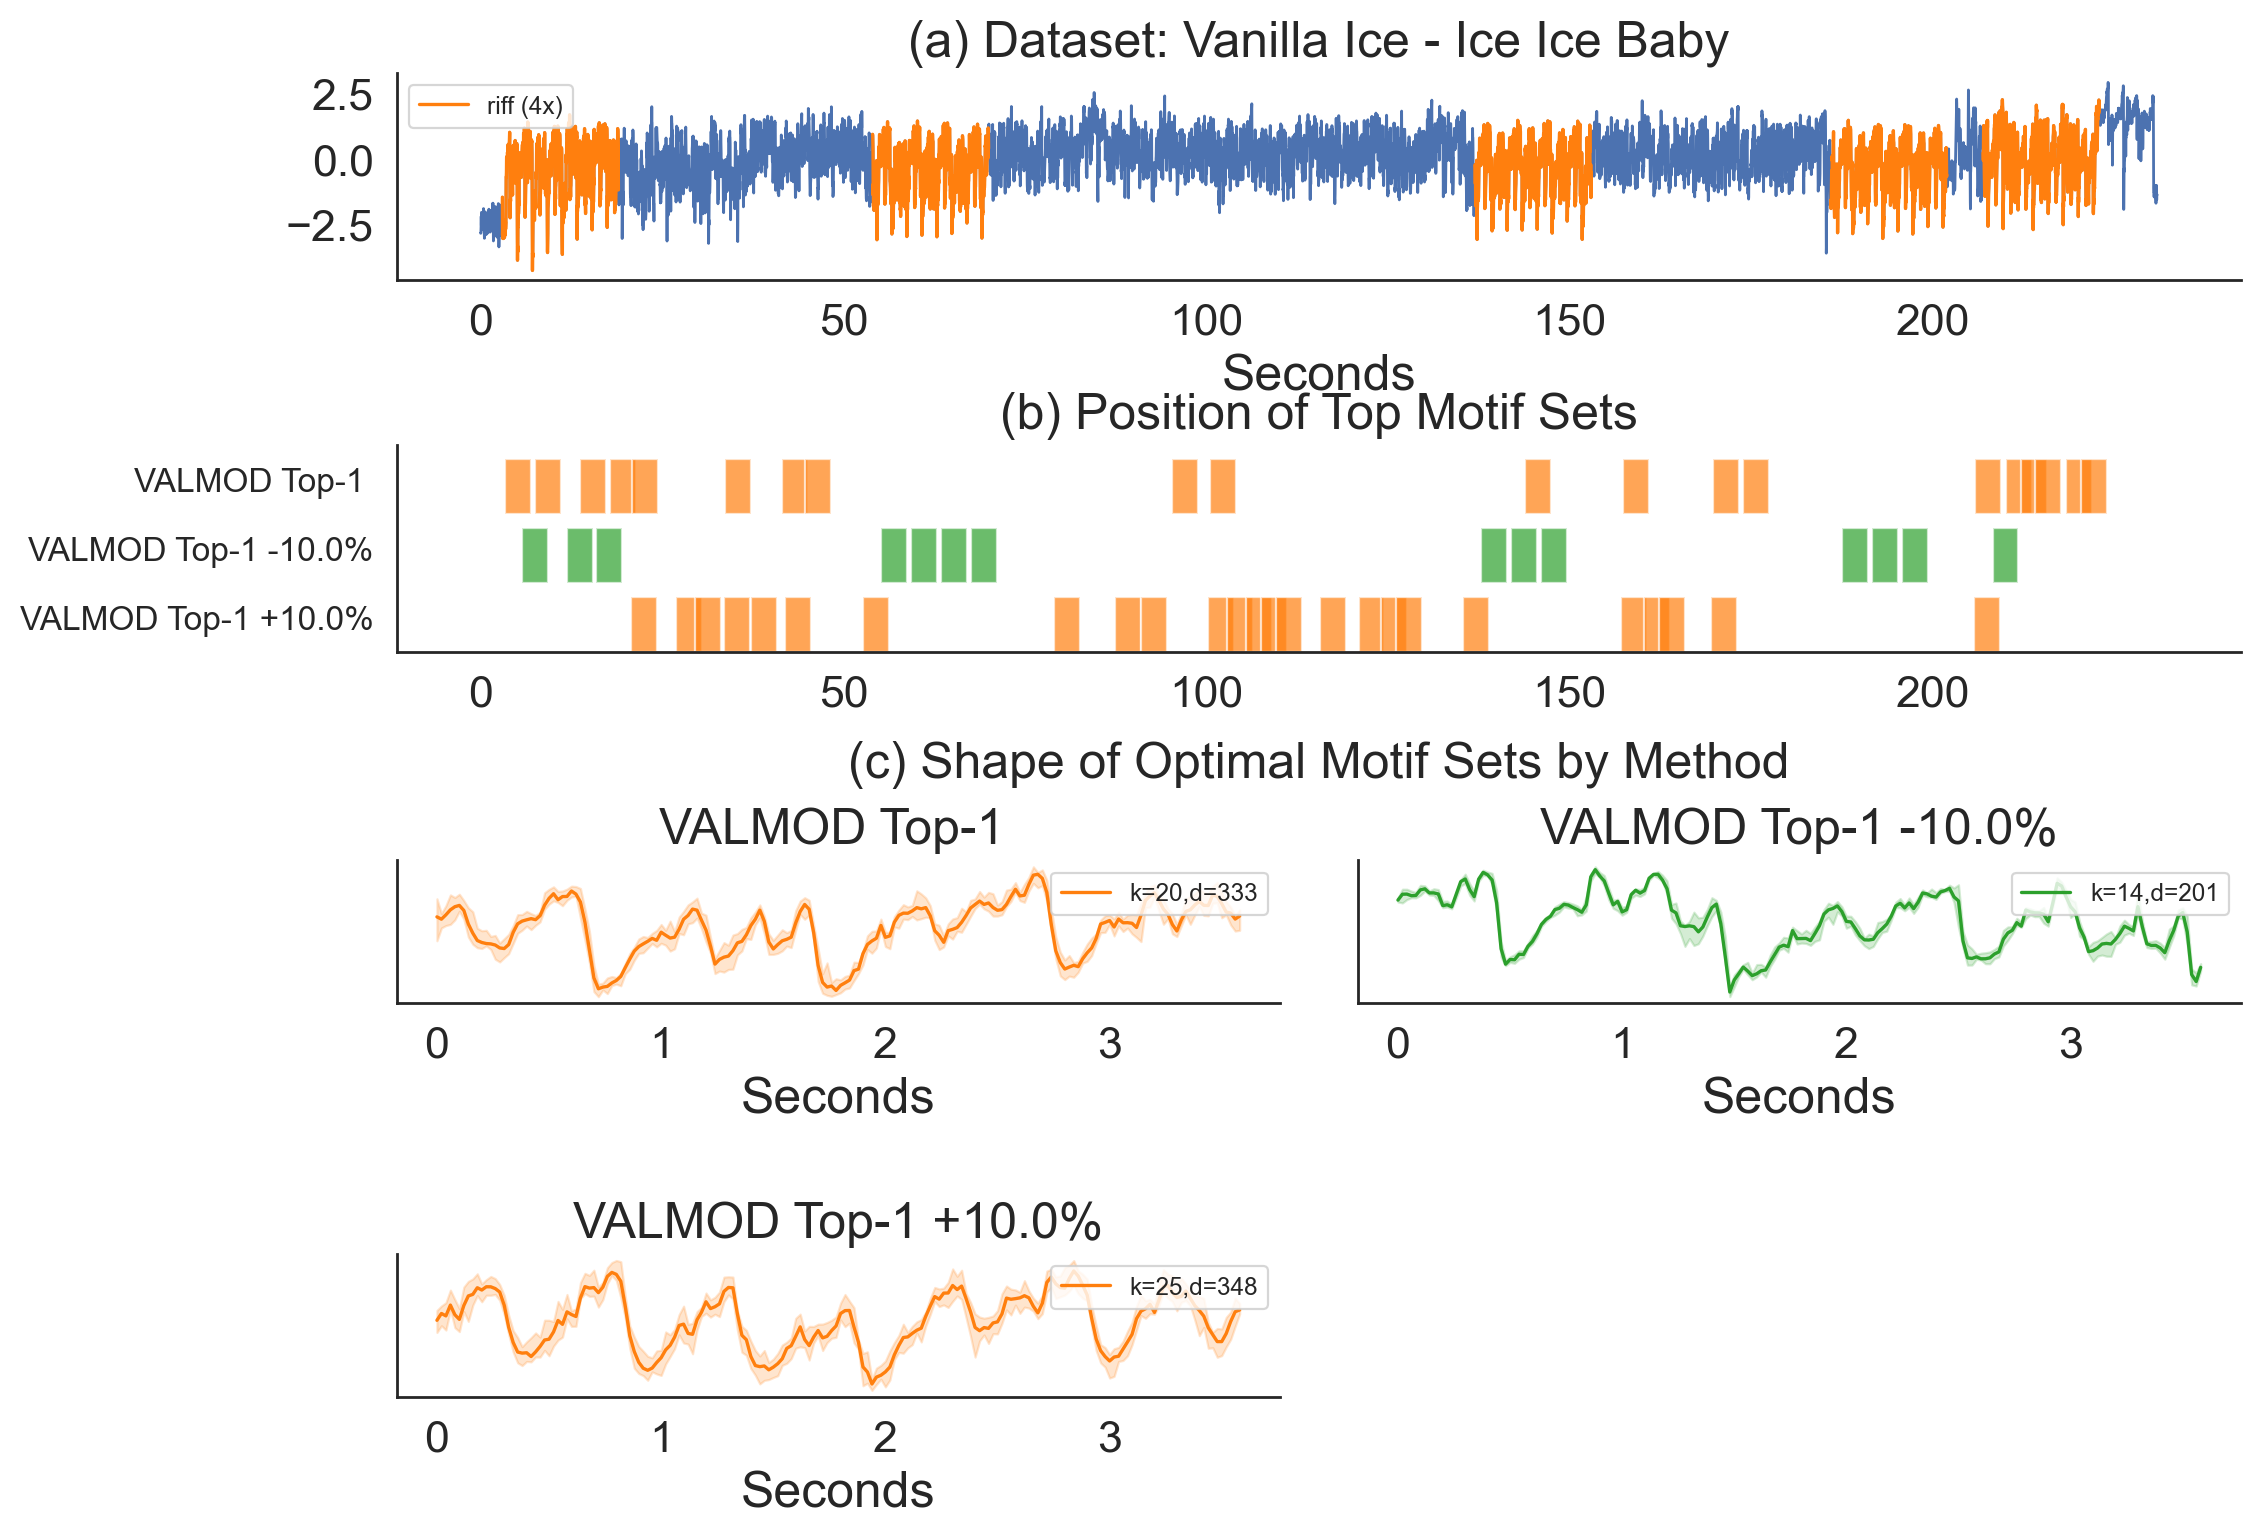

In [10]:
mls = motif_length
max_r=r_top1 * 1.5

ms_all = {}
for e in errors:
    rs = max_r * (1.0 * (1+e))
    mls = np.int32(motif_length * (1-e))
    ms_valmod = list(get_valmod_motif_set_ranged(data, mls, max_r=rs))
    ms_all[format_key(e)] = ms_valmod
    
    
motifsets = to_df(ms_all, "VALMOD", df)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)


VALMOD found 20 repaets but not of the riff. Thus, even given perfect parameterization, it fails to find all repeats.

# Learning Motifs
See Java Code

In [11]:
rs = np.array([r_top1*0.80])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/latent_motifs.jar',
           dataset,
           str(list(rs)),
           str(mls)])

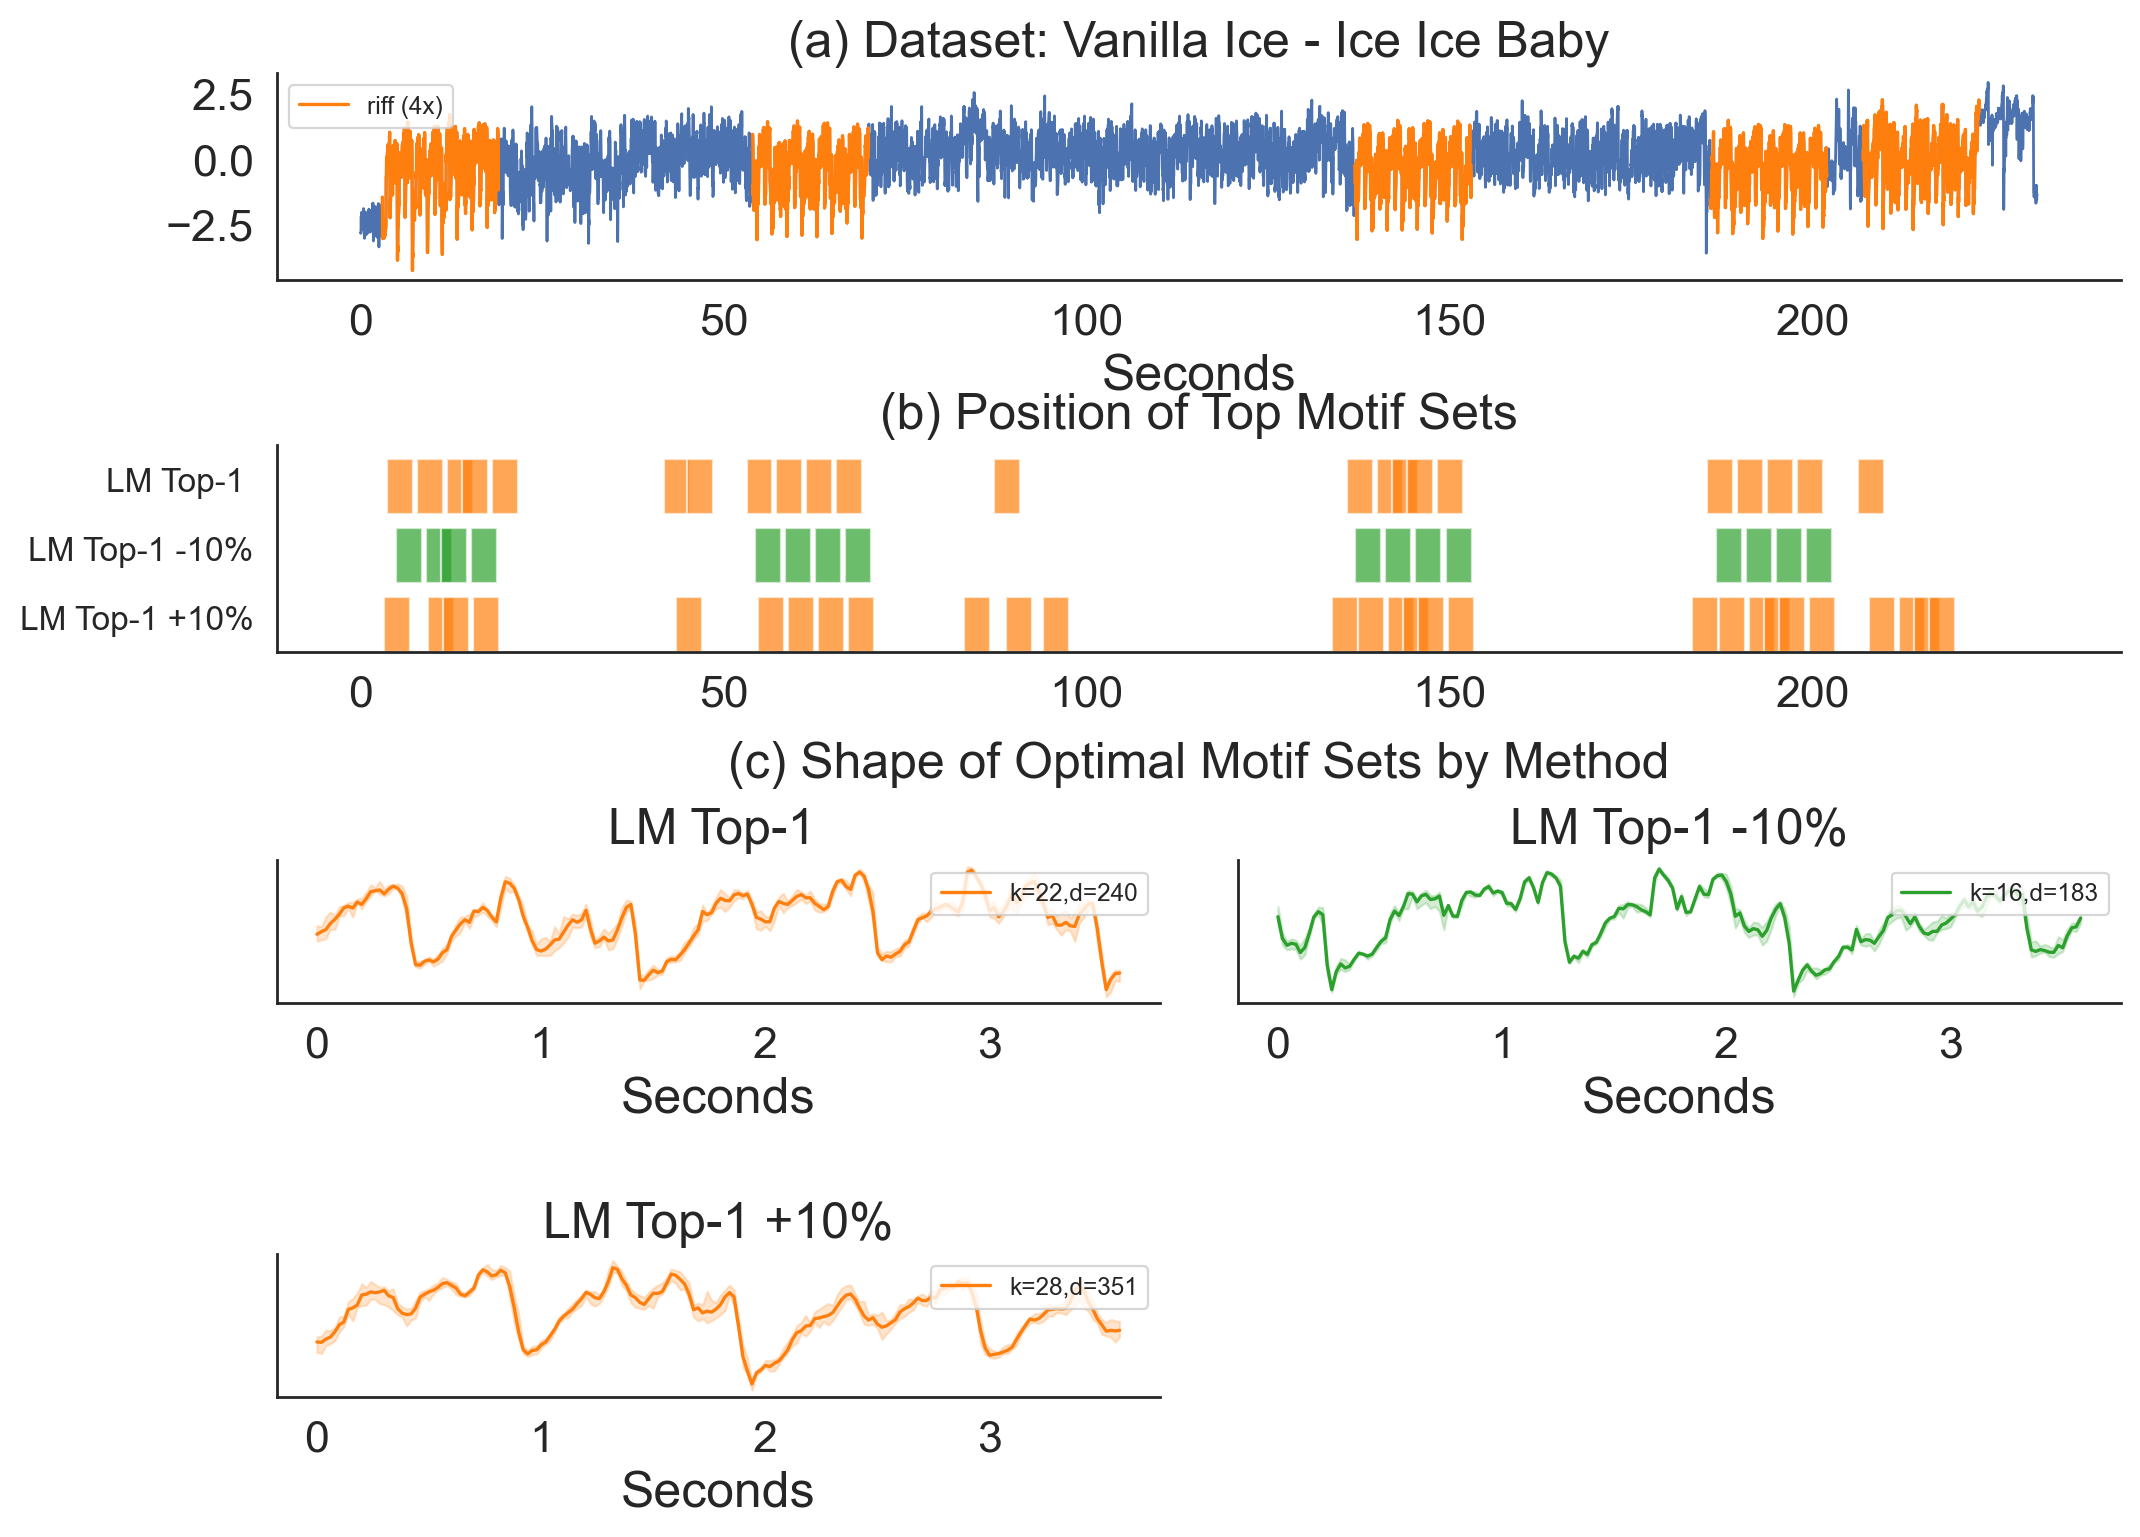

In [12]:
ms_all = {
    "" : [
	[180,386,594,696,903,2091,2247,2658,2864,3071,3277,4364,6792,6998,7103,7205,7412,9276,9482,9689,9896,10311,],
    ], 
    "-10%" : [    
	[241,447,551,757,2718,2924,3131,3338,6852,7059,7266,7473,9336,9543,9750,9957,],
    ],        
    "+10%" : [
	[159,466,570,775,2172,2736,2943,3150,3357,4155,4444,4702,6694,6871,7077,7183,7285,7493,9171,9355,9561,9667,9768,9975,10392,10599,10702,10806,],
    ],
}


motifsets = to_df(ms_all, "LM", df)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)


Results of LM depend heavily on parameterization and initialization of the stochastic gradient descent (SGD). 
LM found 20 repeats of a motif set but misses many occurences of the riff.

# Comparison

We next show a comparison of all methods.

Note that the k-Motiflet algorithm has to recover meaningful motifs without any additional knowledge, while the competitors were provided with inputs with near-optimal parameters, and their results rely heavily on parameterization.

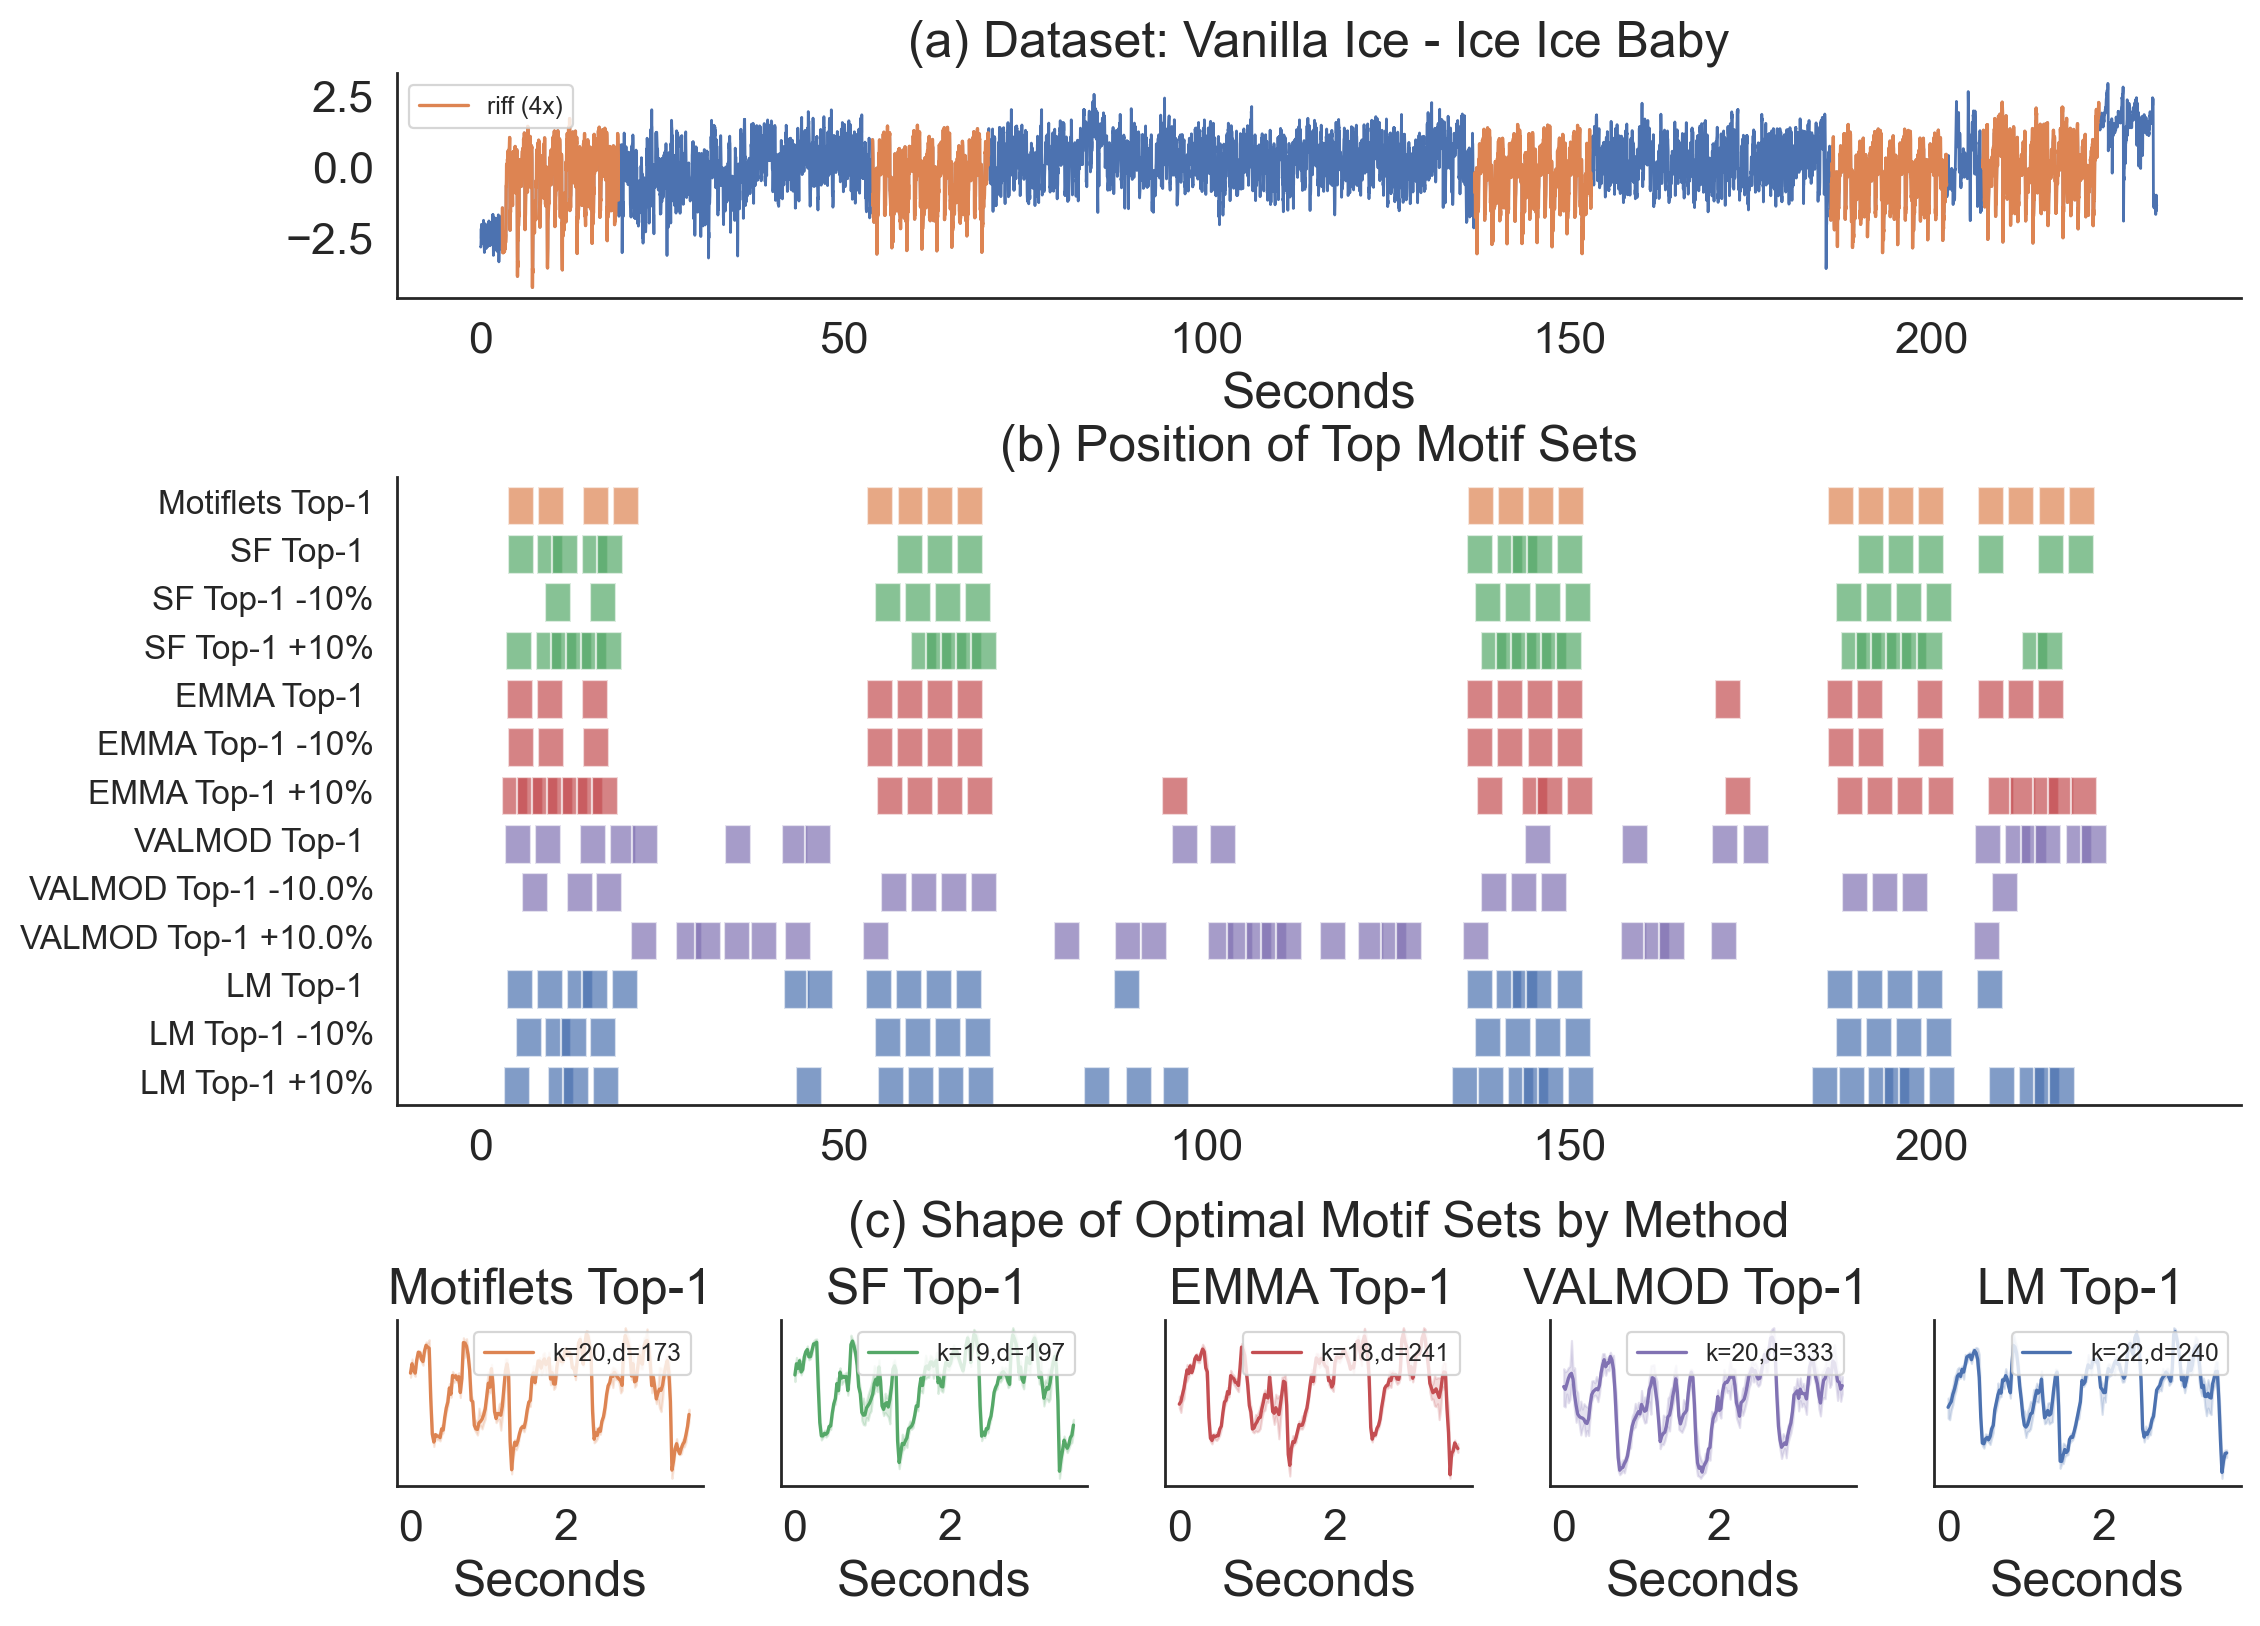

In [13]:
df_all = df.T
df_all.rename(columns={0:"offsets"}, inplace=True)

index = np.array([0, 1, 2, 3, 4])
color_palette=np.array(sns.color_palette())[index]
plot_index=[0, 1, 4, 7, 10, 13, 14, 17, 20, 23]

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, color_palette=color_palette,
                     method_names=df_all.index.values, ground_truth=df_gt, plot_index=plot_index)            

The bottom part of the plot only shows the shape of the optimal motifs, i.e. with optimal parameterization.

Only $k$-Motiflets perfectly identifies the riff.